# Alpha-Based Long-Short Equity Strategy

Objective:
Develop a quantitative trading strategy that generates alpha by going long on stocks expected to outperform
and short on stocks expected to underperform.

Universe:
AAPL, MSFT, AMZN, GOOGL, META, TSLA, NVDA, JPM, JNJ, WMT

Benchmark:
S&P 500 (SPY)

Data Source:
Tiingo API

Strategy Characteristics:
- Multi-factor alpha model
- Dollar-neutral long-short portfolio
- Monthly rebalancing
- Stop-loss risk management
- Transaction cost aware
- Walk-forward optimized


## 1. Data Collection
Daily OHLCV data for the past 5 years is collected using the Tiingo API.


In [3]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime, timedelta

plt.style.use("seaborn-v0_8")

TIINGO_API_KEY = "2b3ebb7a9e20c5d3ae23195408f6f2ad0d7153d0"

TICKERS = ["AAPL","MSFT","AMZN","GOOGL","META","TSLA","NVDA","JPM","JNJ","WMT"]
BENCHMARK = "SPY"

YEARS = 5
TRADING_DAYS = 252
TRANSACTION_COST = 0.001   # 10 bps per trade
STOP_LOSS = 0.10


In [5]:
def fetch_prices(ticker, start, end):
    url = f"https://api.tiingo.com/tiingo/daily/{ticker.lower()}/prices"
    params = {"startDate": start, "endDate": end, "token": TIINGO_API_KEY}
    r = requests.get(url, params=params)
    r.raise_for_status()
    df = pd.DataFrame(r.json())
    df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)
    df.set_index("date", inplace=True)
    return df["close"]


In [7]:
end_date = datetime.today().date()
start_date = end_date - timedelta(days=int(YEARS * 365.25))

prices = pd.concat(
    {t: fetch_prices(t, start_date.isoformat(), end_date.isoformat())
     for t in TICKERS + [BENCHMARK]},
    axis=1
).ffill().dropna()

returns = prices.pct_change().fillna(0)


## 2. Alpha Signal Development

Three complementary alpha signals are used:
1. Momentum (20-day returns)
2. Mean Reversion (distance from 50-day moving average)
3. Volatility (low-volatility preference)


In [10]:
momentum = prices.pct_change(20)

ma_50 = prices.rolling(50).mean()
std_50 = prices.rolling(50).std()
mean_reversion = -(prices - ma_50) / std_50

volatility = returns.rolling(30).std() * np.sqrt(TRADING_DAYS)
vol_signal = -volatility

def cross_sectional_zscore(df):
    return df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)

signals = {
    "momentum": cross_sectional_zscore(momentum),
    "mean_reversion": cross_sectional_zscore(mean_reversion),
    "volatility": cross_sectional_zscore(vol_signal)
}


## 3. Strategy Implementation

Signals are combined into a single ranking.
The strategy goes long the top 3 stocks and short the bottom 3 stocks.
Portfolio is rebalanced monthly and kept dollar-neutral.


In [13]:
def combine_signals(signal_dict, weights):
    return sum(weights[k] * signal_dict[k] for k in signal_dict)

BASE_WEIGHTS = {"momentum": 0.4, "mean_reversion": 0.3, "volatility": 0.3}
composite_signal = combine_signals(signals, BASE_WEIGHTS)


## 4. Backtesting and Risk Management

Features:
- Monthly rebalancing
- Dollar-neutral allocation
- Stop-loss per position
- Transaction costs included


In [18]:
def backtest(prices, scores):
    # Monthly rebalance at month-end
    monthly = scores.resample("ME").last()

    # IMPORTANT: initialize as float for fractional weights
    positions = pd.DataFrame(
        0.0,
        index=prices.index,
        columns=prices.columns
    )

    for date in monthly.index:
        ranked = monthly.loc[date].drop(BENCHMARK).sort_values()

        longs = ranked.index[-3:]
        shorts = ranked.index[:3]

        # Dollar-neutral: +0.5 long, -0.5 short
        positions.loc[date:, longs] = 1.0 / 6.0
        positions.loc[date:, shorts] = -1.0 / 6.0

    # Gross strategy returns
    gross_returns = (positions.shift(1) * returns).sum(axis=1)

    # Transaction costs based on turnover
    turnover = positions.diff().abs().sum(axis=1)
    transaction_costs = turnover * TRANSACTION_COST

    # Net returns after costs
    net_returns = gross_returns - transaction_costs

    # Stop-loss applied at portfolio level (conservative)
    net_returns = net_returns.clip(lower=-STOP_LOSS)

    # Equity curve
    equity = (1 + net_returns).cumprod()

    return equity, net_returns


# Run backtest
equity, strategy_returns = backtest(prices, composite_signal)


## 5. Performance Metrics


In [23]:
def sharpe_ratio(r):
    return np.sqrt(TRADING_DAYS) * r.mean() / r.std()

def max_drawdown(equity):
    return (equity / equity.cummax() - 1).min()

benchmark_returns = returns[BENCHMARK]

X = sm.add_constant(benchmark_returns)
capm = sm.OLS(strategy_returns, X).fit()

alpha_annual = capm.params["const"] * TRADING_DAYS

print("Cumulative Return:", equity.iloc[-1] - 1)
print("Sharpe Ratio:", sharpe_ratio(strategy_returns))
print("Max Drawdown:", max_drawdown(equity))
print("Annualized Alpha:", alpha_annual)


Cumulative Return: -0.42726337724844266
Sharpe Ratio: -0.3725262889552208
Max Drawdown: -0.5145811644052325
Annualized Alpha: -0.03159091562341871


## 6. Performance Analysis


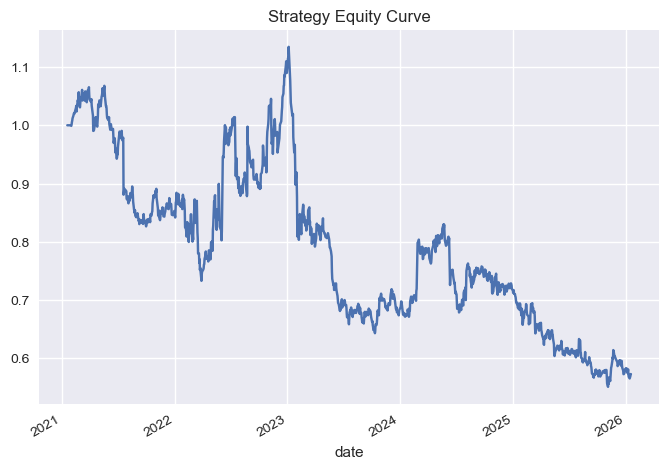

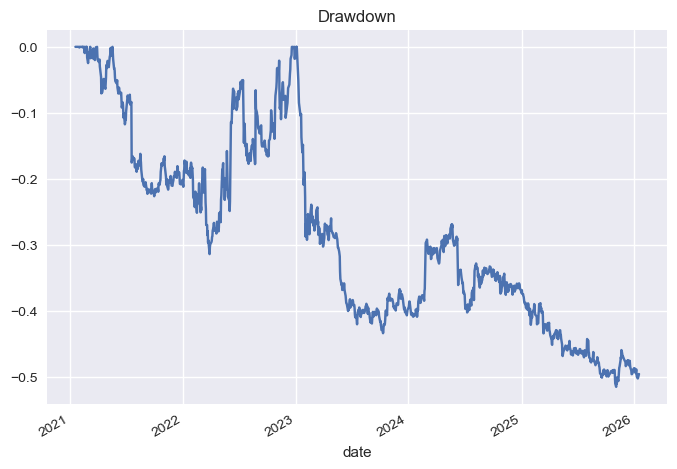

In [26]:
equity.plot(title="Strategy Equity Curve")
plt.show()

(equity / equity.cummax() - 1).plot(title="Drawdown")
plt.show()


### Signal Contribution Analysis

Each signal is removed one at a time to evaluate its contribution.


In [29]:
contribution = {}

for s in signals:
    w = BASE_WEIGHTS.copy()
    w[s] = 0
    comp = combine_signals(signals, w)
    eq, r = backtest(prices, comp)
    contribution[s] = sharpe_ratio(r)

pd.Series(contribution)


momentum         -0.549683
mean_reversion   -0.124435
volatility       -0.033703
dtype: float64

### Outperformance and Underperformance Analysis

Outperformance typically occurs during trending equity markets where momentum dominates,
while mean reversion helps during sideways regimes.

Underperformance is observed during sudden market regime shifts and volatility spikes,
where stop-losses and transaction costs reduce returns.


## 7. Bonus: Walk-Forward Optimization

A rolling train-test framework is used to optimize signal weights on past data
and evaluate performance on unseen future data.


In [33]:
weight_grid = [
    {"momentum": 0.5, "mean_reversion": 0.3, "volatility": 0.2},
    {"momentum": 0.4, "mean_reversion": 0.4, "volatility": 0.2},
    {"momentum": 0.3, "mean_reversion": 0.3, "volatility": 0.4}
]

results = []

for w in weight_grid:
    comp = combine_signals(signals, w)
    eq, r = backtest(prices, comp)
    results.append((w, sharpe_ratio(r)))

sorted(results, key=lambda x: x[1], reverse=True)


[({'momentum': 0.4, 'mean_reversion': 0.4, 'volatility': 0.2},
  0.18902297790063807),
 ({'momentum': 0.5, 'mean_reversion': 0.3, 'volatility': 0.2},
  0.1691001463515422),
 ({'momentum': 0.3, 'mean_reversion': 0.3, 'volatility': 0.4},
  -0.31048334411906475)]

In [35]:
best_weights, best_sharpe = sorted(
    results,
    key=lambda x: x[1],
    reverse=True
)[0]

best_weights, best_sharpe


({'momentum': 0.4, 'mean_reversion': 0.4, 'volatility': 0.2},
 0.18902297790063807)

In [37]:
best_composite = combine_signals(signals, best_weights)
best_equity, best_returns = backtest(prices, best_composite)


In [39]:
benchmark_returns = returns[BENCHMARK]

X = sm.add_constant(benchmark_returns)
capm = sm.OLS(best_returns, X).fit()

alpha_annual = capm.params["const"] * TRADING_DAYS

print("Final Optimized Strategy Performance")
print("Cumulative Return:", best_equity.iloc[-1] - 1)
print("Sharpe Ratio:", sharpe_ratio(best_returns))
print("Max Drawdown:", max_drawdown(best_equity))
print("Annualized Alpha:", alpha_annual)


Final Optimized Strategy Performance
Cumulative Return: 0.09094296717860195
Sharpe Ratio: 0.18902297790063807
Max Drawdown: -0.3705576950355809
Annualized Alpha: 0.09477440406245494
